# AmazonZero

In this notebook we'll explore on how to develop a AI for playing the game of amazons. The tactic is going to be to develop an AI using reinforcement learning. So we'll create an agent which consists of two parts:

1. A predictor: A neural network which predicts the winner: black or white (categorical), given some input data: Square States (categorical), Game States (categorical), Available squares white (integer), Available square black (integer).
2. An actor: A decision maker which monte carlo tree searches through all the possible moves and makes predictions on the board states for each deeper level. It then picks the tree which will result in the highest probability of a win for the acting side.

## The input data

We give AI three different sorts of input. 

### Square states
There are a total of four square states: [Empty, White Amazon, Black Amazon, Fire]. Which we'll encode as follows:

[E, WA, BA, F] = [0, 1, 2, 3] = [[0, 0, 0], [0, 0, 1], [0, 1, 0], [1, 0, 0]]

This is so the network picks up that these are categories and there is no certain order in them. This part of the input is fed seperately to the network.

### Board states
There are a total of four board states: [White selects, White shoots, Black selects, Black shoots]. Which we'll encode in the same way.

[Wse, Wsh, Bse, Bsh] = [0, 1, 2, 3] = [[0, 0, 0], [0, 0, 1], [0, 1, 0], [1, 0, 0]]

And again we will feed this in to the network seperately.

### Available squares white
We will also pass in a single node which contains the information about the number of available square for white. This value will be scaled between 0 and 1, and will be fed into the network seperately. 

### Available square black
We will also pass in a single node which contains the informat about the number of available squares for black. This value will be scaled betwee 0 and 1, and will be fed into the network seperately.

## The output data

The network will try to predict wether white will win or black will win.

White wins: [W] = [1] = [1, 0]
Black wins: [B] = [0] = [0, 1]

# Plan de Campagne

1. Random AI: We will create an AI which will play random moves.
- We still need to implement game end
- We need to implement the player on the server.


2. Smart AI: We will create a smart AI which monte carlo tree searches all possible moves and picks the path which will result in the most possible moves for the acting side

3. Neural Net AI: We will create two AI with an actor and predictor and let them play lots of games against eachother. After a certain amount of games we will update the nodes with the results of all the games in memory. NOTE: This AI uses a exploration and exploitation to explore. Where in the beginning there will be lots of exploration and once it has learned from a lot of previous games the AI will use more and more exploitation.

https://www.youtube.com/watch?v=RfNxXlO6BiA

In [335]:
import numpy as np
from amazonzero.board import Board
from amazonzero.player import RandomPlayer, Actor, Predictor
from amazonzero.main import play_a_game
import matplotlib.pyplot as plt
import random
import tqdm

from sklearn.ensemble import RandomForestClassifier

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

TURN = ['white', 'black']

colormap = {'white': 1, 'black': 2}

In [185]:
board = Board(6, 2)
p1 = RandomPlayer(board, 'white')
p2 = RandomPlayer(board, 'black')

board.matrix

array([[1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 2., 0.],
       [0., 0., 0., 0., 0., 2.]])

[[0. 3. 3. 2. 3. 3.]
 [0. 3. 1. 3. 3. 0.]
 [0. 3. 0. 3. 3. 0.]
 [3. 3. 3. 3. 0. 3.]
 [0. 3. 0. 1. 3. 3.]
 [0. 0. 3. 3. 3. 2.]]
Winner is white


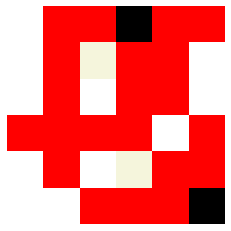

In [186]:
play_a_game(board, p1, p2)

In [378]:
# main loop to fill a Predictor memory with random games.
n_generations = 8
n_games = 500
clf = RandomForestClassifier(max_depth=2, random_state=0)
predictor = Predictor(clf, max_mem=100_000)
epsilon = 0.5  # Explore vs Exploit

for gen in range(n_generations):
    predictor = Predictor(predictor.model, max_mem=100_000)
    actor = Actor()
    
    for i in tqdm.trange(n_games, leave=True):
        board_states = []
        board = Board(6, 2)

        while not board.check_if_ended():
            # Explore
            if random.uniform(0,1) < epsilon:
                next_board = actor.random_move(board)
            # Exploit
            else:
                next_board = actor.move(board, predictor)
            board.matrix = next_board
            board_states.append(next_board.flatten())
            
        board_states = np.array(board_states)

        # append winner to the last column
        n_moves = len(board_states)
        y = np.zeros(n_moves) + 1 if board.winner == "white" else np.zeros(n_moves) + 2

        # create the feature matrix
        feature_matrix = np.concatenate([board_states, y.reshape(1, -1).T], axis=1)
        predictor.memorize(feature_matrix)
        
    predictor.train()

100%|██████████| 500/500 [01:08<00:00,  7.29it/s]


In [383]:
predictor.predict(Xy[:, :-1])

(array([2., 2., 2., ..., 2., 2., 1.]),
 array([[0.45188939, 0.54811061],
        [0.47078529, 0.52921471],
        [0.45872001, 0.54127999],
        ...,
        [0.48502402, 0.51497598],
        [0.48787076, 0.51212924],
        [0.50050952, 0.49949048]]))

In [388]:
import pickle
#create a pickle file
with open("../models/rfg8_500pg.pkl", 'wb') as picklefile:
    pickle.dump(predictor.model, picklefile)